**PROBLEM 1**

Mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
path_to_folder = "ENPM673"
%cd /content/drive/My\ Drive/{path_to_folder}

/content/drive/My Drive/ENPM673


Importing the requied modules

In [ ]:
import cv2
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
from sklearn.cluster import KMeans

Preprocessing

In [ ]:
#  capturing the video file
vid_capture = cv2.VideoCapture('Proj_2/proj2_v2.mp4')
# Get video properties
frame_width = int(vid_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(vid_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = 10
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('Proj_2/output_video3.mp4', fourcc, fps, (frame_width, frame_height))
c = 0
skip_frames = 0

Pipeline Loop
Approach:
1. Capturing the individual frames
2. Processs frames to get the neccessary details
3. Finding the edge lines through hough lines
4. Finding the intersection points of the edges
5. Clustering the intersection points to get corners
6. Verifying the corners by Harris corner method
7. Connecting the corners to get the edges

In [ ]:
while True:
    c+=1
    # capturing individual frames
    ret, img = vid_capture.read()
    if not ret:
        break
    kernel = np.array([[0, 1, 0] , [1, -4, 1] , [0, 1, 0]])
    variance = cv2.filter2D(img, ddepth=cv2.CV_64F, kernel=kernel).var()
    if variance > 105:
        unblur = img
    else:
      skip_frames+=1
      continue
    # Processing each frames to extract the required details
    unblur = cv2.cvtColor(unblur, cv2.COLOR_BGR2GRAY)   # converting to grey scale
    white = np.where(unblur > 210, 255, 0)              # thersholding the pixel intensity
    white = np.uint8(white)
    edge = cv2.Canny(white, 255, 255)                   # edge detection by canny edge detecctor
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])# kernel to sharpen frames
    edge = cv2.filter2D(edge, -1, kernel)               # image sharpening
    lines= cv2.HoughLinesP(edge, 1, np.pi/180, 50, minLineLength=110, maxLineGap=10) # getting the coordinates of the edge lines

    # horizontal and vertical
    horz = []
    vert = []
    for i in lines:
      x_1, y_1, x_2, y_2 = i[0]
      dist = ((x_2-x_1)**2 + (y_2-y_1)**2 )**0.5          # Filtering lines by distance
      if dist<100:
        continue
      # segmenting lines to vertical and horizontal
      elif abs(x_1-x_2)<100:
        vert.append(i)
      elif abs(y_1-y_2)<100:
        horz.append(i)
      # cv2.line(img, (x_1, y_1), (x_2, y_2), (0, 0, 255), 1)

    # finding intersection of the edge lines
    inter_x = []
    inter_y = []
    for i in horz:
      for j in vert:
        x_1, y_1, x_2, y_2 = i[0]
        x_3, y_3, x_4, y_4 = j[0]
        # intersection coordinates formula
        x = ((x_1*y_2 - y_1*x_2)*(x_3-x_4) - (x_1-x_2)*(x_3*y_4 - y_3*x_4))/((x_1-x_2)*(y_3-y_4) - (y_1-y_2)*(x_3-x_4))
        y = ((x_1*y_2 - y_1*x_2)*(y_3-y_4) - (y_1-y_2)*(x_3*y_4 - y_3*x_4))/((x_1-x_2)*(y_3-y_4) - (y_1-y_2)*(x_3-x_4))
        inter_x.append(int(x))
        inter_y.append(int(y))
    data = np.column_stack((inter_x, inter_y))
    # for i, j in zip(inter_x, inter_y):
    #   center = (i, j)
    #   cv2.circle(img, center, 2, (0,0,255), thickness=-1)



    # clustering the intersection points by k means method
    if len(data) <4:
      skip_frames+=1
      continue
    kmeans = KMeans(n_clusters=4, random_state=len(inter_x), n_init="auto")
    kmeans.fit(data)
    centers = kmeans.cluster_centers_
    # sorting centers by clockwise direction
    cx, cy = centers.mean(0)
    x, y = centers.T
    angles = np.arctan2(x-cx, y-cy)
    indices = np.argsort(angles)
    sorted_centers = centers[indices]
    # print(sorted_centers)

    # printing the lines in the frame
    for idx, i in enumerate(sorted_centers):
      center = (int(i[0]), int(i[1]))
      # connecting the intersection points to get the edges
      if idx==1:
        center_1 = (int(i[0]), int(i[1]))
        center_2 = (int(sorted_centers[2][0]), int(sorted_centers[2][1]))
      elif idx ==2:
        center_1 = (int(i[0]), int(i[1]))
        center_2 = (int(sorted_centers[3][0]), int(sorted_centers[3][1]))
      elif idx ==3:
        center_1 = (int(i[0]), int(i[1]))
        center_2 = (int(sorted_centers[0][0]), int(sorted_centers[0][1]))
      else:
        center_1 = (int(i[0]), int(i[1]))
        center_2 = (int(sorted_centers[1][0]), int(sorted_centers[1][1]))
      cv2.circle(img, center, 4, (0,0,255), thickness=-1)
      cv2.line(img, center_1, center_2, (235, 206, 135), 3)

    # finding corners by harris corner method for verification
    harris_img = np.float32(unblur)
    harris_img = cv2.cornerHarris(harris_img, 2,3,0.05)
    corner = cv2.dilate(harris_img, None)
    img[corner > 0.31 * corner.max()] = [0, 255, 0]
    # writing the video
    out.write(img)
# finding the percentage of frames that was effectively utilized after Laplacian-based filtering


Calculating the frames used

In [ ]:
utilized = c-skip_frames
frames_perc = (utilized)/c*100
print("number of frames that was effectively utilized after Laplacian-based filtering is", utilized)
print("percentage of frames that was effectively utilized after Laplacian-based filtering", frames_perc)
cv2.destroyAllWindows()
vid_capture.release()
out.release()

number of frames that was effectively utilized after Laplacian-based filtering is 197
percentage of frames that was effectively utilized after Laplacian-based filtering 50.90439276485789


Results:
1. When filtering the blurry frames about 40 percentage of the frames was filtered.
2. The hough line parameters can be optimised to suitable values by trial and error.
3. The quality of the edges was remained consistent in most of the frames, though in some frames the edges was misplaced when the camera movement was fast.

**PROBLEM 2 a.**

Getting the images

In [ ]:
os.chdir("/content/drive/My Drive/ENPM673/Proj_2/project2-image-set")
items = os.listdir()
items.sort(reverse = True)
images = []

Function to get the homography

In [ ]:
def image_stitch(img_1, img_2):
  # declarring the SIFT feature detector
  descriptor = cv2.xfeatures2d.SIFT_create()
  keyp1, feat1 = descriptor.detectAndCompute(img_1, None)
  keyp2, feat2 = descriptor.detectAndCompute(img_2, None)
  keyp1_list = []
  keyp2_list = []
  # Appending the key points
  for i in keyp1:
    keyp1_list.append(np.float32(i.pt))
  for i in keyp2:
    keyp2_list.append(np.float32(i.pt))
  # Declaring the matcher function
  match_maker = cv2.BFMatcher()
  matches = match_maker.knnMatch(feat1, feat2, 2)
  matches_list = []
  # Filtering the good matches
  for j in matches:
    if j[0].distance < j[1].distance*0.8 and len(j) ==2:
      matches_list.append((j[0].trainIdx, j[0].queryIdx))
  pt_A = np.array([])
  pt_B = np.array([])
  # Finding the homography matrix
  if len(matches_list)>4:
    pt_A = np.float32([keyp1_list[k] for (_, k) in matches_list])
    pt_B = np.float32([keyp2_list[k] for (k, _) in matches_list])
    homograph, stat = cv2.findHomography(pt_A, pt_B, cv2.RANSAC, 4.0)
    return homograph

Function to wrap the final image

In [ ]:
def wrap(img_1, img_2, homograph):
  # Wrapping the image by giving suitable dimensions
    result = cv2.warpPerspective(img_1, homograph, (img_1.shape[1] + img_2.shape[1], img_1.shape[0]))
    result[0:img_2.shape[0], 0:img_2.shape[1]] = img_2
    return result

Function to crop the final image to elimnate the black pixels

In [ ]:
def crop(result):
    # thesholding the pixel intensities
    _,thresh = cv2.threshold(result,1,255,cv2.THRESH_BINARY)
    # finding contours
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    # finding contour of the black pixel
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    return x,y,w,h

Appending all images to a list

In [ ]:
for i in items:
  img = cv2.imread(i)
  images.append(img)

Function call

Approach:
1. Stitching the image 1 and 2
2. Stitching the image 3 and 4
3. Finally stitching the two images from the step 1 and 2

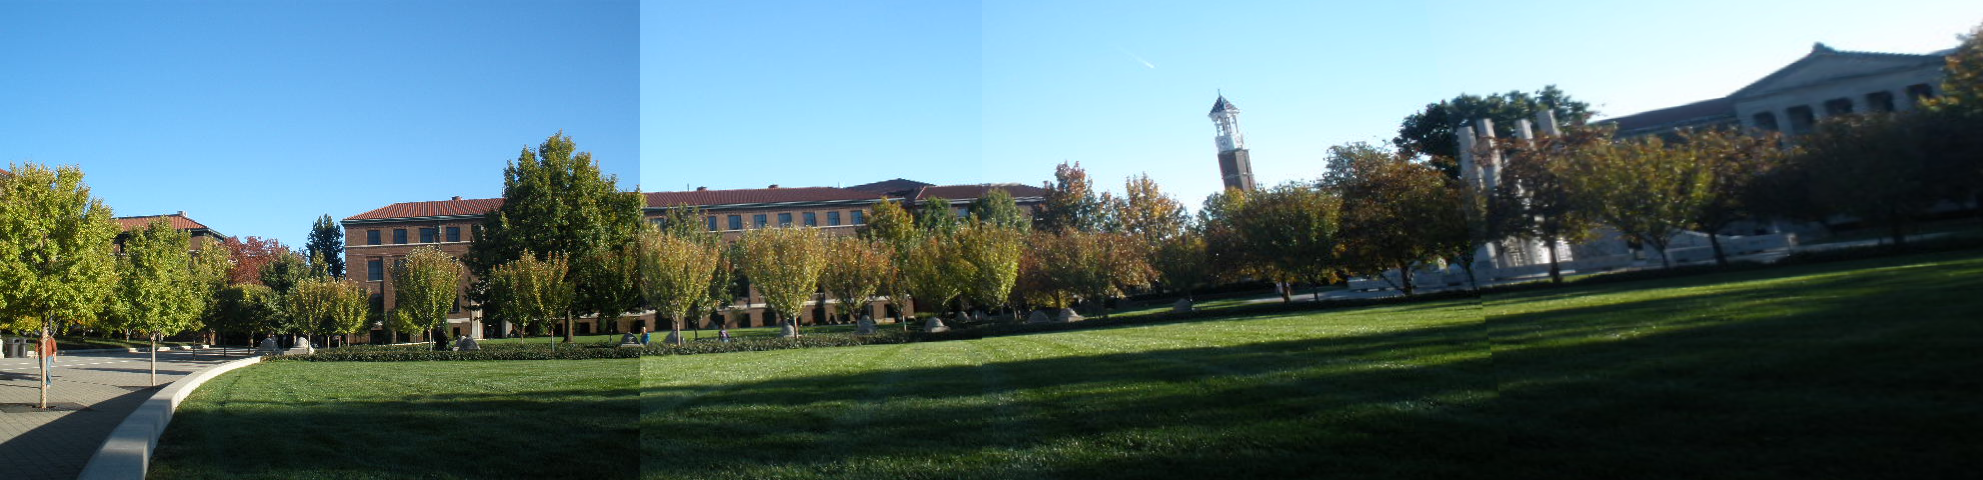

In [ ]:
# stitching the image 1 and 2
H_1 = image_stitch(cv2.cvtColor(images[1], cv2.COLOR_BGR2GRAY), cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY))
base_image_1 = wrap(images[1], images[0], H_1)
x1,y1,w1,h1 = crop(cv2.cvtColor(base_image_1, cv2.COLOR_BGR2GRAY))
base_image_1 = base_image_1[y1:y1+h1,x1:x1+w1-30]
# cv2_imshow(base_image_1)
# stitching the image 2 and 3
H_2 = image_stitch(cv2.cvtColor(images[3], cv2.COLOR_BGR2GRAY), cv2.cvtColor(images[2], cv2.COLOR_BGR2GRAY))
base_image_2 = wrap(images[3], images[2], H_2)
x2,y2,w2,h2 = crop(cv2.cvtColor(base_image_2, cv2.COLOR_BGR2GRAY))
base_image_2 = base_image_2[y2:y2+h2,x2:x2+w2-30]
# cv2_imshow(base_image_2)
# stitching the two stitched images
H_3 = image_stitch(cv2.cvtColor(base_image_2, cv2.COLOR_BGR2GRAY), cv2.cvtColor(base_image_1, cv2.COLOR_BGR2GRAY))
base_image = wrap(base_image_2, base_image_1, H_3)
x3,y3,w3,h3 = crop(cv2.cvtColor(base_image, cv2.COLOR_BGR2GRAY))
base_image = base_image[y3:y3+h3,x3:x3+w3-30]
cv2_imshow(base_image)

Results:
1. Since the individual image was taken with little drift and rotation the quality of the stiched image is compromised.
2. We can see the image at the right most is wrapped extremely compared to the first base image
3. After stitching the stiched edges are evident which can be elimnated by smoothening the the edges.

**PROBLEM 2 b.**

In general, why does panoramic mosaicing work better when the camera is only allowed to rotate at its camera
center?

Panoramic mosaicing will work better when the camera is only allowed to rotate at its camera center because,
1. The parallax effect will be minimised, thus the objects will remain same.
2. Also the vertical displacement of the adjacent images will be minimal, thus improving the panaroma quality.
Thus the quaity can be close enough as if the image was taken by a wide angle camera.